# Who's That Pokemon?
### Pokemon Type Identification
COMP 562-001 Final Project By Jordan Bean

Adapted From "Pokemon type identify" By Josué Nascimento. Kaggle Post: https://www.kaggle.com/code/josutk/pokemon-type-identify/notebook

### **Description:**

This notebook will revolve around the development of a convolutional neural network (CNN) trained on images of Pokemon and their respective type(s) from generations 1 through 7.
The end goal will be to test this model with the newest generation of Pokemon, generation 9, to determine how well the model can identify Pokemon types based solely on their images.

### (1) Data Cleaning

In [1]:
import pandas as pd
pokemon_types = pd.read_csv('pokemon_types.csv')

nums = []
for i in range(1, pokemon_types.shape[0]+1):
    nums.append(i)
pokemon_types['pkn'] = nums

IMG_DIR = 'pokemon_images'
from os import listdir
from os.path import isfile, join
pokemon_imgs = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]

In [2]:
import re
dataframe_imgs = pd.DataFrame([])
images = []
pokemon_nums = []
for img in pokemon_imgs:
    if not re.search('-', img):
        pkn = img.split('.')
        n = re.sub("[^0-9]", "", pkn[0])
        path = IMG_DIR +'/' +str(img)
        images.append(path)
        pokemon_nums.append(n)
        
dataframe_imgs['images'] = images
dataframe_imgs['pkn'] = pokemon_nums
dataframe_imgs['pkn'] = dataframe_imgs['pkn'].astype(int)
dataframe_imgs['pkn'] = dataframe_imgs['pkn'].astype(int)
result = pokemon_types.merge(dataframe_imgs, left_on='pkn', right_on='pkn')
result.head()

,Name,Type1,Type2,pkn,images
0,bulbasaur,Grass,Poison,1,pokemon_images/1.png
1,ivysaur,Grass,Poison,2,pokemon_images/2.png
2,venusaur,Grass,Poison,3,pokemon_images/3.png
3,charmander,Fire,NaN,4,pokemon_images/4.png
4,charmeleon,Fire,NaN,5,pokemon_images/5.png


In [3]:
import plotly.graph_objects as go
select = ['Grass', 'Electric']
result = result[result['Type1'].isin(select)]

fig = go.Figure()

fig.add_trace(go.Bar(x=[result['Type1'].value_counts().index[0]],
                     y=[result['Type1'].value_counts()[0]],
                     marker_color='green',
                     name='Grass'
                     ))

fig.add_trace(go.Bar(x=[result['Type1'].value_counts().index[1]],
                     y=[result['Type1'].value_counts()[1]],
                     marker_color='yellow',
                     name='Electric'
                    ))
fig.update_layout({
        'title': 'Pokemon Distribution: Grass Versus Electric',
        'title_x': 0.5,
        'width': 500, 
        'height': 400
})
fig.show()

In [4]:
import os
from shutil import copyfile
os.mkdir('train/')
os.mkdir('test/')
os.mkdir('val/')
for class_ in result['Type1'].unique():
    os.mkdir('train/'+str(class_)+'/')
    os.mkdir('test/'+str(class_)+'/')
    os.mkdir('val/'+str(class_)+'/')

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    result, result['Type1'],test_size=0.33, stratify=result['Type1'])

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33,stratify=y_test)

In [6]:
from shutil import copyfile, copy2

for image,type_  in zip(X_train['images'], y_train):
    copy2(image, 'train/'+type_)

for image,type_ in zip(X_test['images'], y_test):
    copy2(image, 'test/'+type_)
    
for image,type_ in zip(X_val['images'], y_val):
    copy2(image, 'val/'+type_)

In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

train = datagen.flow_from_directory('train/')
test = datagen.flow_from_directory('test/')
val = datagen.flow_from_directory('val/')

2022-12-09 23:03:52.166703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 66 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


### (2) Model Engineering

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator

def build():
    model = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3
    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    model.summary()
    return model
model = build()
history = model.fit_generator(train, epochs=30, validation_data=val)

2022-12-09 23:04:05.845391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 batch_normalization (BatchN  (None, 255, 255, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        8

/var/folders/t7/spjj5c_n1hn40c9y780nfzfr0000gn/T/ipykernel_15825/402399056.py:37: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
3/3 [==============================] - 9s 2s/step - loss: 1.1224 - acc: 0.5455 - val_loss: 5.7047 - val_acc: 0.6364
Epoch 2/30
3/3 [==============================] - 5s 2s/step - loss: 0.6125 - acc: 0.7424 - val_loss: 2.5269 - val_acc: 0.7273
Epoch 3/30
3/3 [==============================] - 5s 1s/step - loss: 0.4201 - acc: 0.8939 - val_loss: 2.6673 - val_acc: 0.6364
Epoch 4/30
3/3 [==============================] - 5s 3s/step - loss: 0.2877 - acc: 0.9394 - val_loss: 1.6167 - val_acc: 0.6364
Epoch 5/30
3/3 [==============================] - 5s 1s/step - loss: 0.2173 - acc: 0.9394 - val_loss: 1.4992 - val_acc: 0.6364
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 0.2135 - acc: 0.9545 - val_loss: 0.8342 - val_acc: 0.7273
Epoch 7/30
3/3 [==============================] - 5s 1s/step - loss: 0.1240 - acc: 1.0000 - val_loss: 0.6927 - val_acc: 1.0000
Epoch 8/30
3/3 [==============================] - 5s 2s/step - loss: 0.1388 - acc: 0.9848 - val_loss: 0.5142 - 

In [9]:
predict = model.predict(test)

1/1 [==============================] - 1s 716ms/step


In [10]:
fig = go.Figure()
epochs = []
for i in range(len(history.history['acc'])):
    epochs.append(i)
fig.add_trace(go.Scatter(x=epochs,y=history.history['acc'], mode='lines',name='train'))
fig.add_trace(go.Scatter(x=epochs,y=history.history['val_acc'], mode='lines',name='val'))
fig.update_layout({
        'width': 500, 
        'height': 400

})
fig.show()

In [11]:
import numpy as np

from sklearn.metrics import classification_report
predict_frame = pd.DataFrame([])
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

              precision    recall  f1-score   support

    Electric       0.18      0.25      0.21         8
       Grass       0.45      0.36      0.40        14

    accuracy                           0.32        22
   macro avg       0.32      0.30      0.31        22
weighted avg       0.36      0.32      0.33        22



In [12]:
import matplotlib.pyplot as plt

def show_wrong_classification(y_test, predict, result):
    tmp = result[result.index.isin(y_test.index)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    i=0
    for imag, true, pred in zip(tmp['images'], tmp['Type1'], predict):
        if true!=pred:
            if i <3:
                img = Image.open(imag)
                fig = plt.figure()
                ax[i].imshow(img)
                ax[i].set_title(str(pred))
                i+=1

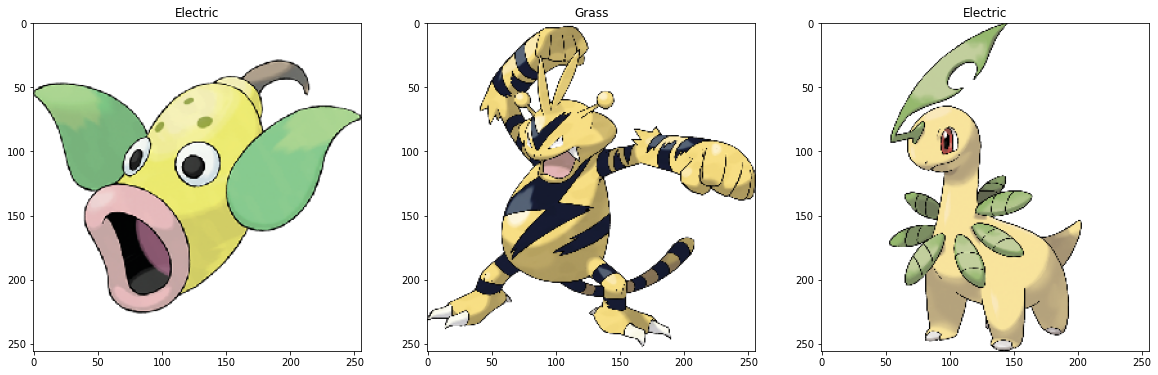

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [13]:
from PIL import Image
show_wrong_classification(y_test, predict_frame['category'], result)

  0%|          | 0/2 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB pr

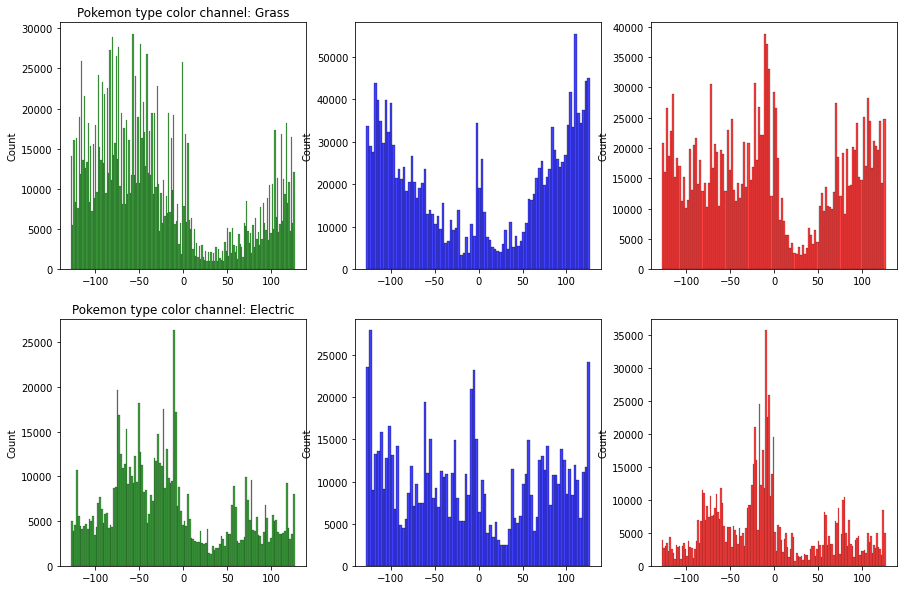

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(2,3,figsize=(15,10))
k =0
# import cv2
list_b =[]
list_r = []
list_g = []
from tqdm import tqdm
for type_ in tqdm(result['Type1'].unique()):
    tmp = result[result['Type1']==type_]
    for img in tmp['images']:
        img = cv2.imread(img)
        b, g, r = cv2.split(img)
        color = 'blue'
        for i in b:
            for j in i:
                if j != 0:
                    list_b.append(j)
        color = 'green'
        for i in g:
            for j in i:
                if j != 0:
                    list_g.append(j)
        color = 'red'
        for i in r:
            for j in i:
                if j != 0:
                    list_r.append(j)
    sns.histplot(list_g, ax=axes[k, 0], color='g')
    sns.histplot(list_b, ax=axes[k, 1], color='b')
    sns.histplot(list_r, ax=axes[k, 2], color='r')
    axes[k, 0].set_title('Pokemon type color channel: ' + type_)
    if type_ =='Electric':
        list_g_e = list_g
        list_b_e = list_b
        list_r_e = list_r
    else:
        list_g_g = list_g
        list_b_g = list_b
        list_r_g = list_r
    list_b =[]
    list_r = []
    list_g = []
    
    k += 1

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

g_electric = np.std(np.array(list_g_e), axis=0)
r_electric = np.std(np.array(list_r_e), axis=0)
b_electric = np.std(np.array(list_b_e), axis=0)


g_grass = np.std(np.array(list_g_g), axis=0)
r_grass = np.std(np.array(list_r_g), axis=0)
b_grass = np.std(np.array(list_b_g), axis=0)

fig = make_subplots(rows=1, cols=2, subplot_titles=("Electric std channel","Grass std channel"))
fig.add_trace(go.Scatter(
    y=[b_electric, g_electric, g_electric],
    x=['blue', 'green', 'red'],
    mode='markers',
    marker=dict(size=[b_electric, g_electric, r_electric],
                color=['blue', 'green', 'red'],
                showscale=True)
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=[b_grass, g_grass, r_grass],
    x=['blue', 'green', 'red'],
    mode='markers',
    marker=dict(size=[b_grass, g_grass, r_grass],
                color=['blue', 'green', 'red'],
                showscale=True)
), row=1, col=2)
fig.update_layout(showlegend=False)
fig.update_layout({
        'width': 850, 
        'height': 400

})
fig.show()

In [16]:
grass = result[result['Type1']=='Grass']
stds = []
values = []
for image in grass['images']:
    img = cv2.imread(image)
    b, g, r = cv2.split(img)
    for i in r:
        for j in i:
            if j != 0:
                stds.append(j)       
    std = np.mean(np.array(stds), axis=0)
    values.append(std)
    stds = []
grass['stds'] = values

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [17]:
grass = grass.sort_values(by='stds', ascending=False)

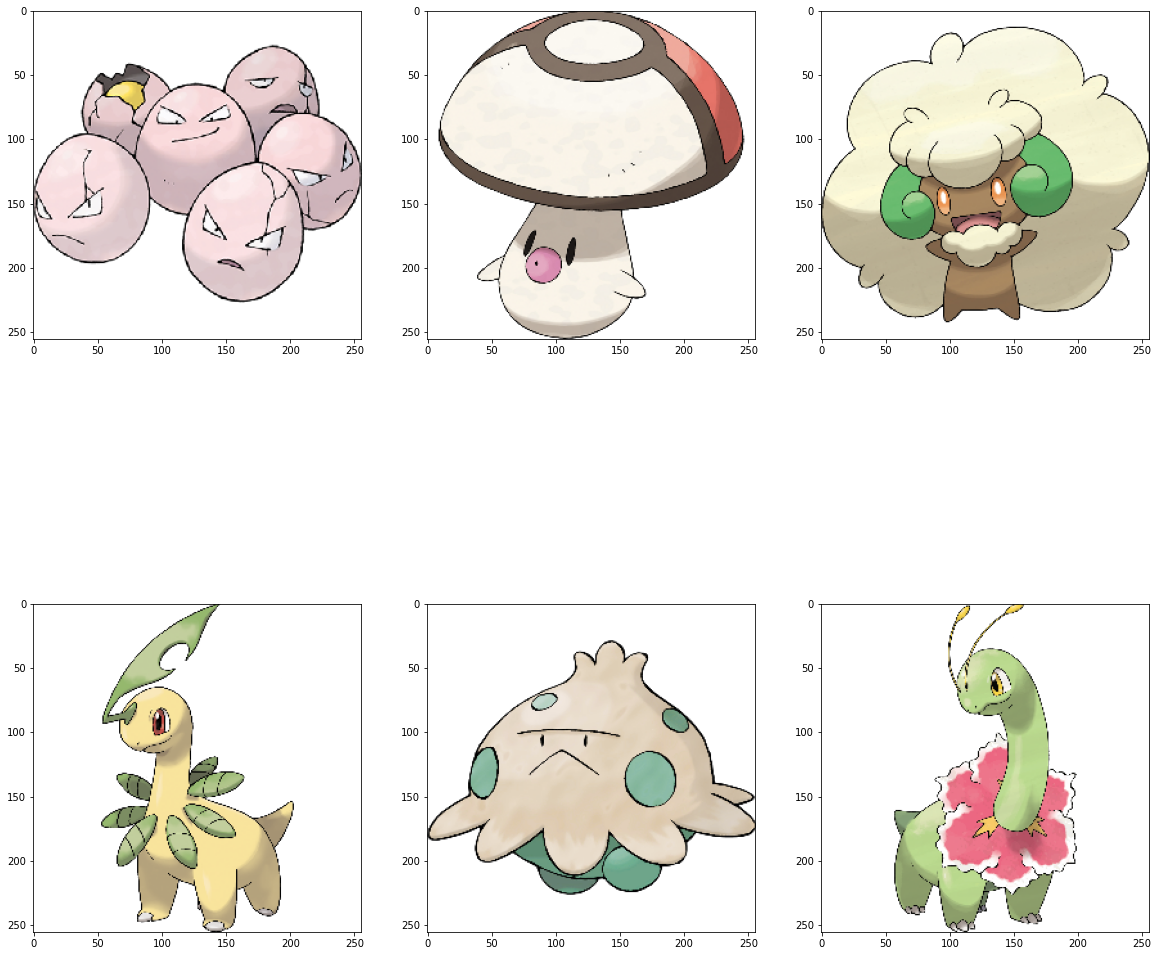

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [18]:
i = 0
j = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for imag in grass['images']:
    if i == 1 and j ==3:
        break
    if j > 2:
        i =1
        j = 0
    img = Image.open(imag)
    fig = plt.figure()
    ax[i][j].imshow(img)
    j+=1

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
/var/folders/t7/spjj5c_n1hn40c9y780nfzfr0000gn/T/ipykernel_15825/2067602560.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



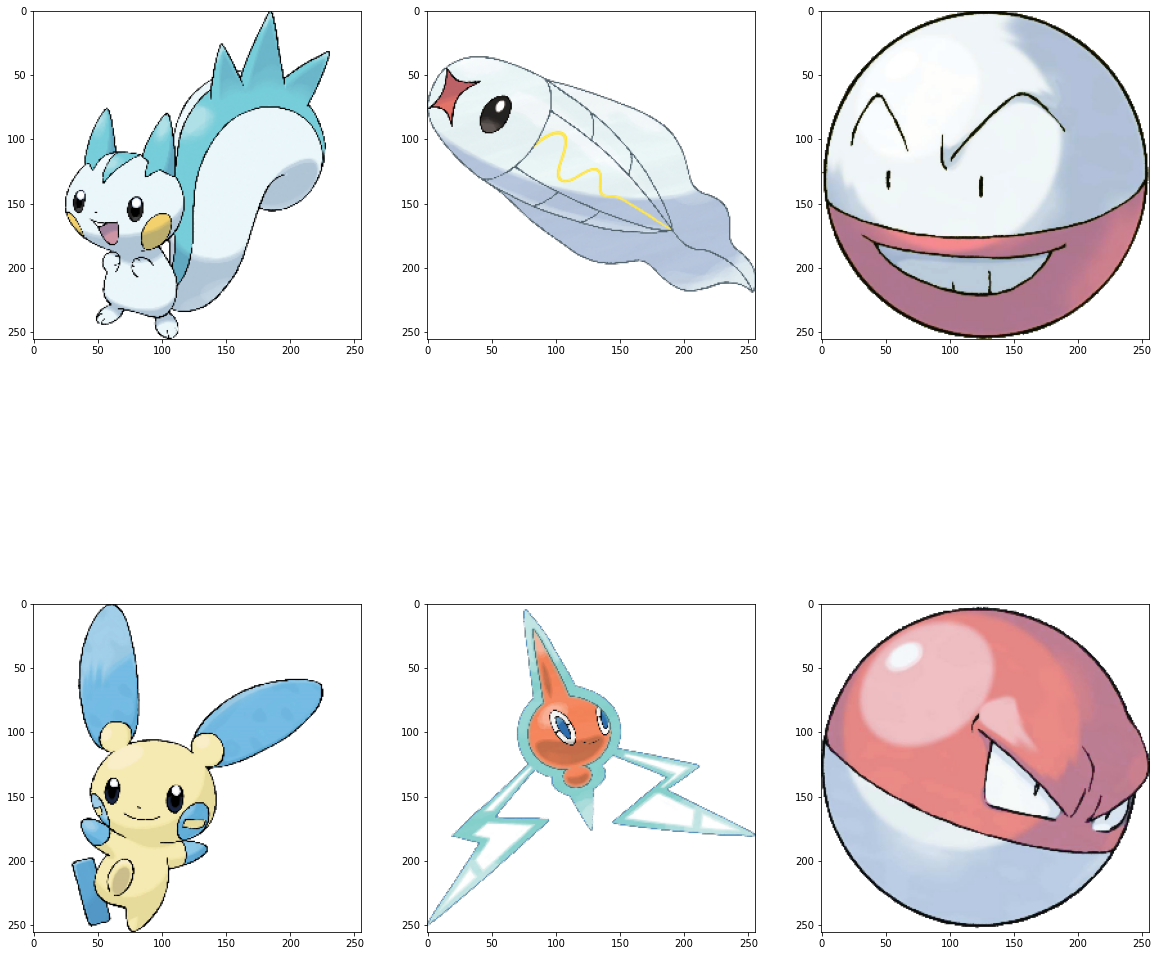

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
electric = result[result['Type1']=='Electric']
stds = []
values = []
for image in electric['images']:
    img = cv2.imread(image)
    b, g, r = cv2.split(img)
    for i in b:
        for j in i:
            if j != 0:
                stds.append(j)       
    std = np.mean(np.array(stds), axis=0)
    values.append(std)
    stds = []
electric['stds'] = values
electric = electric.sort_values(by='stds', ascending=False)
i = 0
j = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for imag in electric['images']:
    if i == 1 and j ==3:
        break
    if j > 2:
        i =1
        j = 0
    img = Image.open(imag)
    fig = plt.figure()
    ax[i][j].imshow(img)
    j+=1

### (3) Data Augmentation

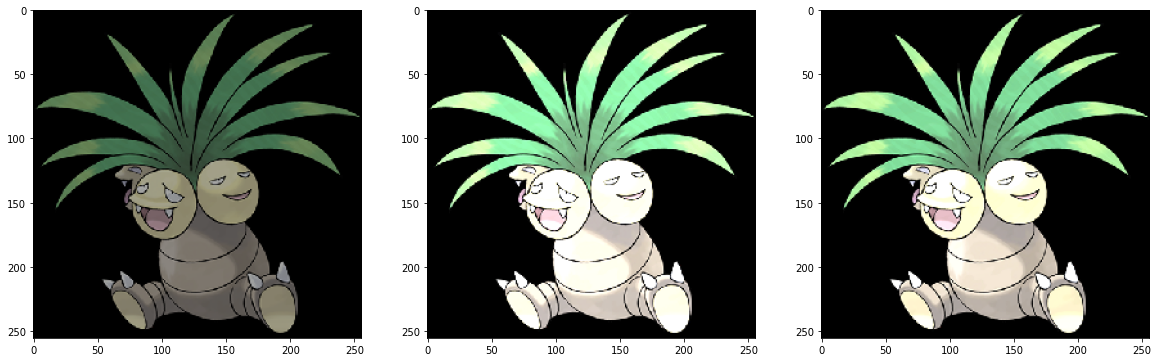

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
from numpy import expand_dims
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
img = load_img(grass['images'][102])
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(brightness_range=[0.2,1.5])
it = datagen.flow(samples, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
for i in range(3):
    fig = plt.figure()
    batch = it.next()
    image = batch[0].astype('uint8')
    ax[i].imshow(image)
pyplot.show()

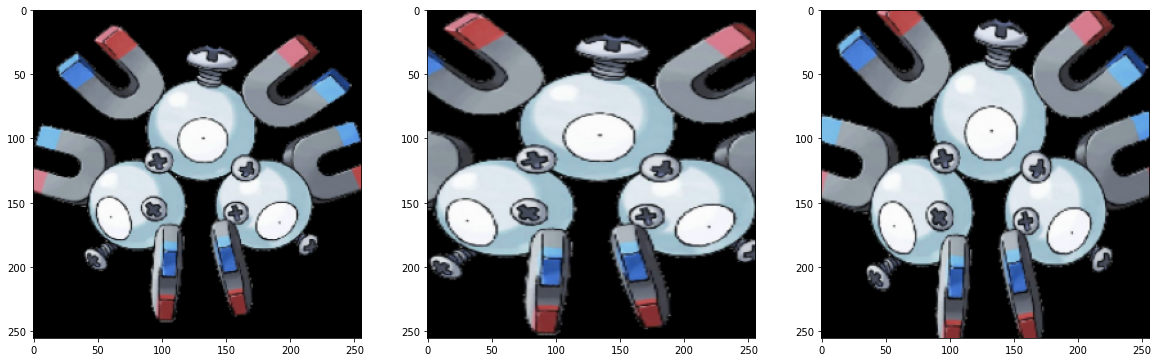

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [35]:
img = load_img(electric['images'][81])
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(zoom_range=[0.5, 1.0])
it = datagen.flow(samples, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
for i in range(3):
    fig = plt.figure()
    batch = it.next()
    image = batch[0].astype('uint8')
    ax[i].imshow(image)
pyplot.show()

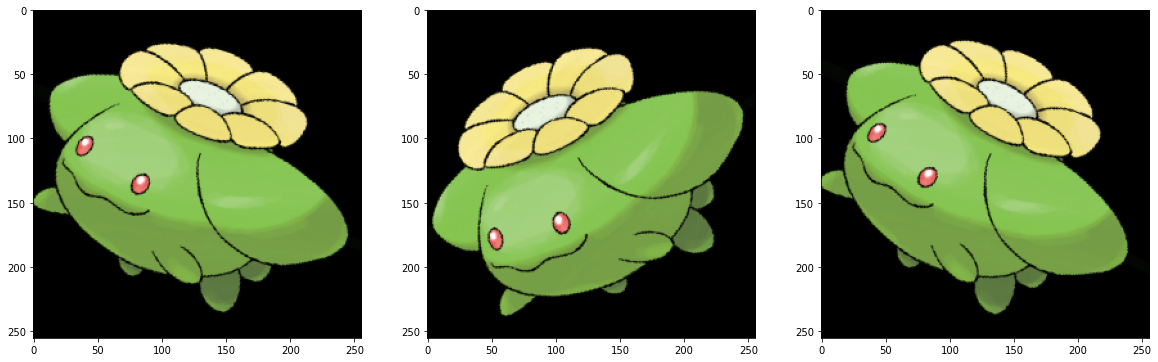

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [40]:
img = load_img(grass['images'][187])
data = img_to_array(img)
samples = expand_dims(data, 0)
datagen = ImageDataGenerator(rotation_range=35)
it = datagen.flow(samples, batch_size=1)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
for i in range(3):
    fig = plt.figure()
    batch = it.next()
    image = batch[0].astype('uint8')
    ax[i].imshow(image)
pyplot.show()

In [41]:
datagentrain = ImageDataGenerator(rotation_range=35, 
                                 zoom_range=[0.5, 1.0], 
                                 brightness_range=[0.2,1.5])

datagen = ImageDataGenerator()

train = datagentrain.flow_from_directory('train/')
test = datagen.flow_from_directory('test/')
val = datagen.flow_from_directory('val/')

Found 66 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [42]:
model = build()
history = model.fit_generator(train, epochs=30, validation_data=val)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 255, 255, 32)      416       
                                                                 
 batch_normalization_4 (Batc  (None, 255, 255, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 84, 84, 64)       

/var/folders/t7/spjj5c_n1hn40c9y780nfzfr0000gn/T/ipykernel_15825/2591029628.py:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
3/3 [==============================] - 14s 3s/step - loss: 1.0211 - acc: 0.6515 - val_loss: 61.1792 - val_acc: 0.6364
Epoch 2/30
3/3 [==============================] - 7s 2s/step - loss: 2.3228 - acc: 0.4242 - val_loss: 15.1668 - val_acc: 0.6364
Epoch 3/30
3/3 [==============================] - 6s 2s/step - loss: 0.8683 - acc: 0.6364 - val_loss: 11.3538 - val_acc: 0.4545
Epoch 4/30
3/3 [==============================] - 6s 1s/step - loss: 0.7314 - acc: 0.6818 - val_loss: 14.6124 - val_acc: 0.3636
Epoch 5/30
3/3 [==============================] - 6s 2s/step - loss: 0.6474 - acc: 0.6515 - val_loss: 12.8900 - val_acc: 0.3636
Epoch 6/30
3/3 [==============================] - 7s 2s/step - loss: 0.6793 - acc: 0.6818 - val_loss: 8.7170 - val_acc: 0.3636
Epoch 7/30
3/3 [==============================] - 6s 3s/step - loss: 0.6523 - acc: 0.6970 - val_loss: 5.4424 - val_acc: 0.4545
Epoch 8/30
3/3 [==============================] - 6s 2s/step - loss: 0.5496 - acc: 0.8030 - val_loss: 3.4

In [44]:
fig = go.Figure()
epochs = []
for i in range(len(history.history['acc'])):
    epochs.append(i)
fig.add_trace(go.Scatter(x=epochs,y=history.history['acc'], mode='lines',name='train'))
fig.add_trace(go.Scatter(x=epochs,y=history.history['val_acc'], mode='lines',name='val'))
fig.update_layout({
        'width': 500, 
        'height': 400

})
fig.show()

In [45]:
predict_frame = pd.DataFrame([])
predict = model.predict_generator(test)
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

/var/folders/t7/spjj5c_n1hn40c9y780nfzfr0000gn/T/ipykernel_15825/1537018070.py:2: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



              precision    recall  f1-score   support

    Electric       0.38      0.75      0.50         8
       Grass       0.67      0.29      0.40        14

    accuracy                           0.45        22
   macro avg       0.52      0.52      0.45        22
weighted avg       0.56      0.45      0.44        22



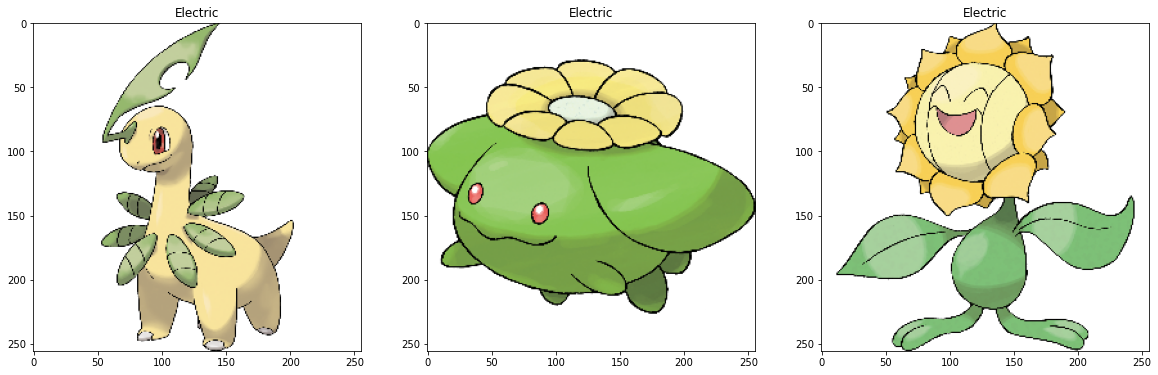

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [46]:
show_wrong_classification(y_test, predict_frame['category'], result)